## Machine Translation using Attention Model 

English to Spanish Translation

## Preparing the Data

As always, let's import all the required modules and set the random seeds for reproducability.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

import pandas as pd
from sklearn.model_selection import train_test_split
import unicodedata
import re
import torchtext.data as ttd

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
!python -m spacy download es_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [4]:
f = open('/gdrive/My Drive/ColabNotebooks/spa.txt', encoding='UTF-8').read().strip().split('\n')  

In [5]:
lines = f

In [6]:
# sample size (try with smaller sample size to reduce computation)
num_examples = 30000 

# creates lists containing each pair
original_word_pairs = [[w for w in l.split('\t')] for l in lines[:]]

In [7]:
data = pd.DataFrame(original_word_pairs)
data = data.drop(2, axis=1)
data.columns = ["eng", "es"]
data.head()
#data = pd.DataFrame(original_word_pairs, columns=["eng", "es"])

,eng,es
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)
train, valid = train_test_split(train, test_size=0.2)

In [9]:
train.to_csv('/gdrive/My Drive/ColabNotebooks/train-en-es.tsv',sep='\t', index=False)
valid.to_csv('/gdrive/My Drive/ColabNotebooks/valid-en-es.tsv',sep='\t', index=False)
test.to_csv('/gdrive/My Drive/ColabNotebooks/test-en-es.tsv',sep='\t', index=False)

In [10]:
spacy_es = spacy.load('es_core_news_sm')
spacy_en = spacy.load('en')

In [11]:
def tokenize_es(text):
    """
    Tokenizes Spanish text from a string into a list of strings
    """
    return [tok.text for tok in spacy_es.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [12]:
SRC = Field(tokenize = tokenize_es, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [13]:
train_dataset = ttd.TabularDataset(
    path= '/gdrive/My Drive/ColabNotebooks/train-en-es.tsv',
    format='tsv',
    skip_header=True,
    fields=[('es', SRC), ('eng',TRG)]
)

valid_dataset = ttd.TabularDataset(
    path= '/gdrive/My Drive/ColabNotebooks/valid-en-es.tsv',
    format='tsv',
    skip_header=True,
    fields=[('es', SRC), ('eng',TRG)]
)

test_dataset = ttd.TabularDataset(
    path= '/gdrive/My Drive/ColabNotebooks/test-en-es.tsv',
    format='tsv',
    skip_header=True,
    fields=[('es', SRC), ('eng',TRG)]
)

In [14]:
SRC.build_vocab(train_dataset, min_freq = 2)
TRG.build_vocab(train_dataset, min_freq = 2)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
len(train_dataset.examples), len(valid_dataset.examples), len(test_dataset.examples)

20072

In [17]:
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128

train_iterator = BucketIterator(train_dataset,
                            batch_size=TRAIN_BATCH_SIZE,
                            sort_key=lambda x: len(x.text),
                            device = device)

valid_iterator = BucketIterator(valid_dataset,
                            batch_size=VALID_BATCH_SIZE,
                            sort_key=lambda x: len(x.text),
                            device = device)

test_iterator = BucketIterator(test_dataset,
                            batch_size=TEST_BATCH_SIZE,
                            sort_key=lambda x: len(x.text),
                            device = device)

In [18]:
for i,batch in enumerate(train_iterator):
  src = batch.es
  trg = batch.eng
  print(src)
  print(trg)
  break

tensor([[   2,    6,   63,  ...,    1,    1,    1],
        [   2,    9,   50,  ...,    1,    1,    1],
        [   2,   77,   54,  ...,    1,    1,    1],
        ...,
        [   2,    6, 1234,  ...,    1,    1,    1],
        [   2,   34,  196,  ...,    1,    1,    1],
        [   2,    9,   80,  ...,    1,    1,    1]], device='cuda:0')
tensor([[   2,   93,    6,  ...,    1,    1,    1],
        [   2,    9,   45,  ...,    1,    1,    1],
        [   2,  499,   43,  ...,    1,    1,    1],
        ...,
        [   2, 1937,    6,  ...,    1,    1,    1],
        [   2, 5261,   16,  ...,    1,    1,    1],
        [   2,    8,    9,  ...,    1,    1,    1]], device='cuda:0')


In [19]:
for i,batch in enumerate(valid_iterator):
  src = batch.es
  trg = batch.eng
  print(src)
  print(trg)
  break

tensor([[   2,  119,   31,  ...,    1,    1,    1],
        [   2,   23, 1891,  ...,    1,    1,    1],
        [   2,    8,   65,  ...,    1,    1,    1],
        ...,
        [   2,  311,   15,  ...,    1,    1,    1],
        [   2,    6,  425,  ...,    1,    1,    1],
        [   2,    5, 2456,  ...,    4,    3,    1]], device='cuda:0')
tensor([[   2,  121,   12,  ...,    1,    1,    1],
        [   2,   46, 3742,  ...,    1,    1,    1],
        [   2,    7,   74,  ...,    1,    1,    1],
        ...,
        [   2,  168,   25,  ...,    1,    1,    1],
        [   2,  584,   24,  ...,    1,    1,    1],
        [   2,   24, 2594,  ...,    1,    1,    1]], device='cuda:0')


In [20]:
for i,batch in enumerate(test_iterator):
  src = batch.es
  trg = batch.eng
  print(src)
  print(trg)
  break

tensor([[  2,  86,  36,  ...,   1,   1,   1],
        [  2,  37,  40,  ...,   1,   1,   1],
        [  2,   5, 898,  ...,   1,   1,   1],
        ...,
        [  2,  13, 232,  ...,   1,   1,   1],
        [  2,   9, 340,  ...,   1,   1,   1],
        [  2, 660,  52,  ...,   1,   1,   1]], device='cuda:0')
tensor([[  2, 273,  19,  ...,   1,   1,   1],
        [  2,   7,  42,  ...,   1,   1,   1],
        [  2,  13, 888,  ...,   1,   1,   1],
        ...,
        [  2, 437,  97,  ...,   1,   1,   1],
        [  2,   9, 139,  ...,   1,   1,   1],
        [  2, 687,  19,  ...,   1,   1,   1]], device='cuda:0')


## Building the Model

### Encoder

In [21]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

### Encoder Layer

In [22]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

### Mutli Head Attention Layer

In [23]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Position-wise Feedforward Layer

In [24]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder

In [25]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Decoder Layer


In [26]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq

In [27]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Training the Seq2Seq Model

In [28]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

Then, use them to define our whole sequence-to-sequence encapsulating model.

In [29]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,321,693 trainable parameters


In [31]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [32]:
model.apply(initialize_weights);

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

In [33]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

Next, we define our loss function, making sure to ignore losses calculated over `<pad>` tokens.

In [34]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [35]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.es
        trg = batch.eng
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [36]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.es
            trg = batch.eng

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

We then define a small function that we can use to tell us how long an epoch takes.

In [37]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

In [38]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 55s
	Train Loss: 3.797 | Train PPL:  44.560
	 Val. Loss: 2.482 |  Val. PPL:  11.970
Epoch: 02 | Time: 0m 54s
	Train Loss: 2.162 | Train PPL:   8.687
	 Val. Loss: 1.746 |  Val. PPL:   5.730
Epoch: 03 | Time: 0m 55s
	Train Loss: 1.582 | Train PPL:   4.864
	 Val. Loss: 1.482 |  Val. PPL:   4.401
Epoch: 04 | Time: 0m 54s
	Train Loss: 1.263 | Train PPL:   3.535
	 Val. Loss: 1.333 |  Val. PPL:   3.793
Epoch: 05 | Time: 0m 54s
	Train Loss: 1.061 | Train PPL:   2.889
	 Val. Loss: 1.271 |  Val. PPL:   3.563
Epoch: 06 | Time: 0m 54s
	Train Loss: 0.921 | Train PPL:   2.512
	 Val. Loss: 1.246 |  Val. PPL:   3.477
Epoch: 07 | Time: 0m 54s
	Train Loss: 0.819 | Train PPL:   2.268
	 Val. Loss: 1.236 |  Val. PPL:   3.442
Epoch: 08 | Time: 0m 53s
	Train Loss: 0.738 | Train PPL:   2.091
	 Val. Loss: 1.236 |  Val. PPL:   3.441
Epoch: 09 | Time: 0m 53s
	Train Loss: 0.673 | Train PPL:   1.960
	 Val. Loss: 1.242 |  Val. PPL:   3.461
Epoch: 10 | Time: 0m 53s
	Train Loss: 0.620 | Train PPL

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [39]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.235 | Test PPL:   3.438 |


## Inference

In [40]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('es_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

In [41]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

First, we'll get an example from the training set.

In [42]:
example_idx = 8

src = vars(train_dataset.examples[example_idx])['es']
trg = vars(train_dataset.examples[example_idx])['eng']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['tom', 'got', 'into', 'mary', "'s", 'car', '.']
trg = ['tom', 'se', 'subió', 'al', 'auto', 'de', 'mary', '.']


Our translation looks pretty good, although our model changes *is walking by* to *walks by*. The meaning is still the same.

In [43]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['tom', 'se', 'subió', 'al', 'auto', 'de', 'mary', '.', '<eos>']


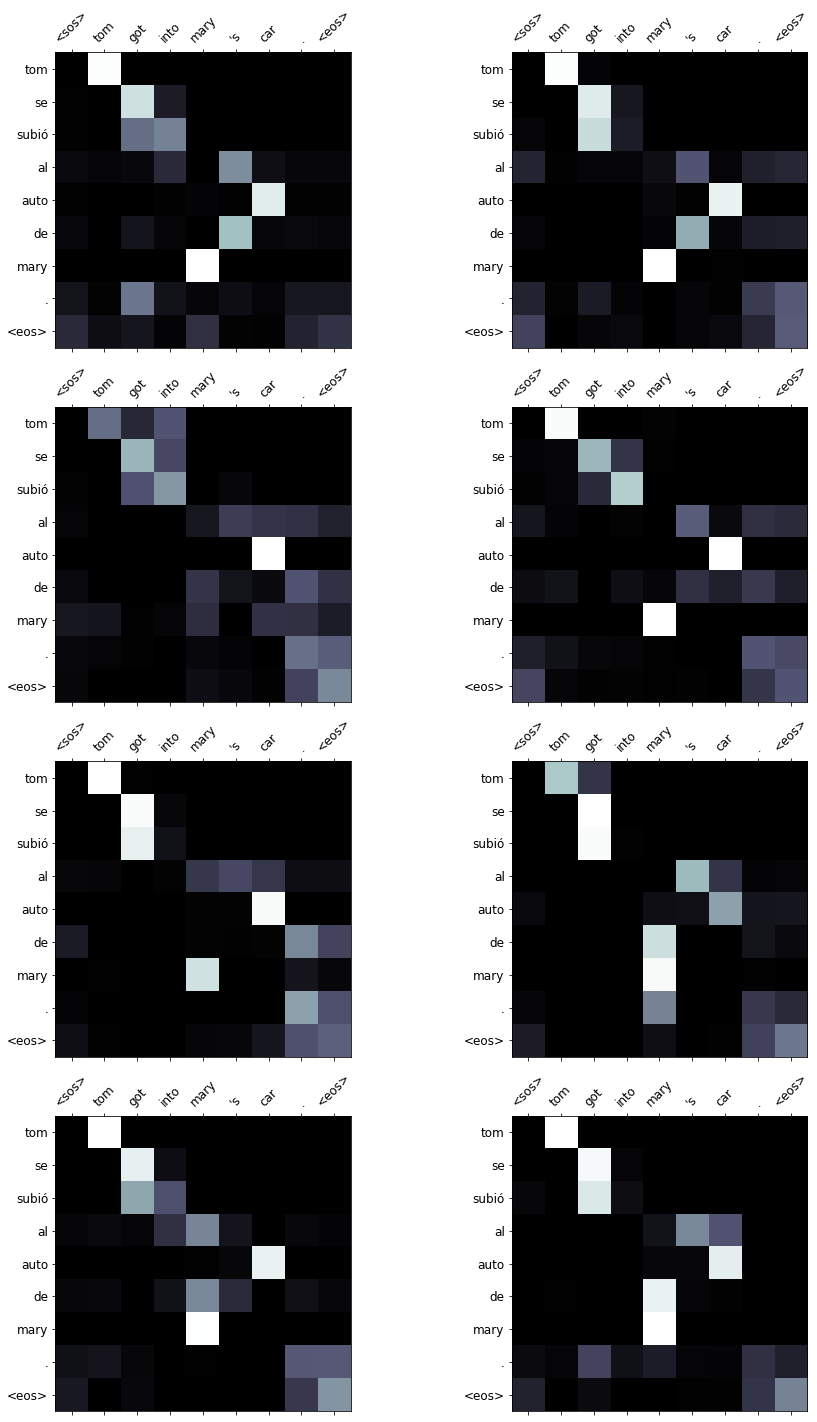

In [44]:
display_attention(src, translation, attention)

Next, let's get an example the model has not been trained on from the validation set.

In [45]:
example_idx = 6

src = vars(valid_dataset.examples[example_idx])['es']
trg = vars(valid_dataset.examples[example_idx])['eng']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['i', 'want', 'to', 'be', 'rich', '.']
trg = ['quiero', 'ser', 'rica', '.']


The model translates it by switching *is running* to just *running*, but it is an acceptable swap.

In [46]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['quiero', 'ser', 'rico', '.', '<eos>']


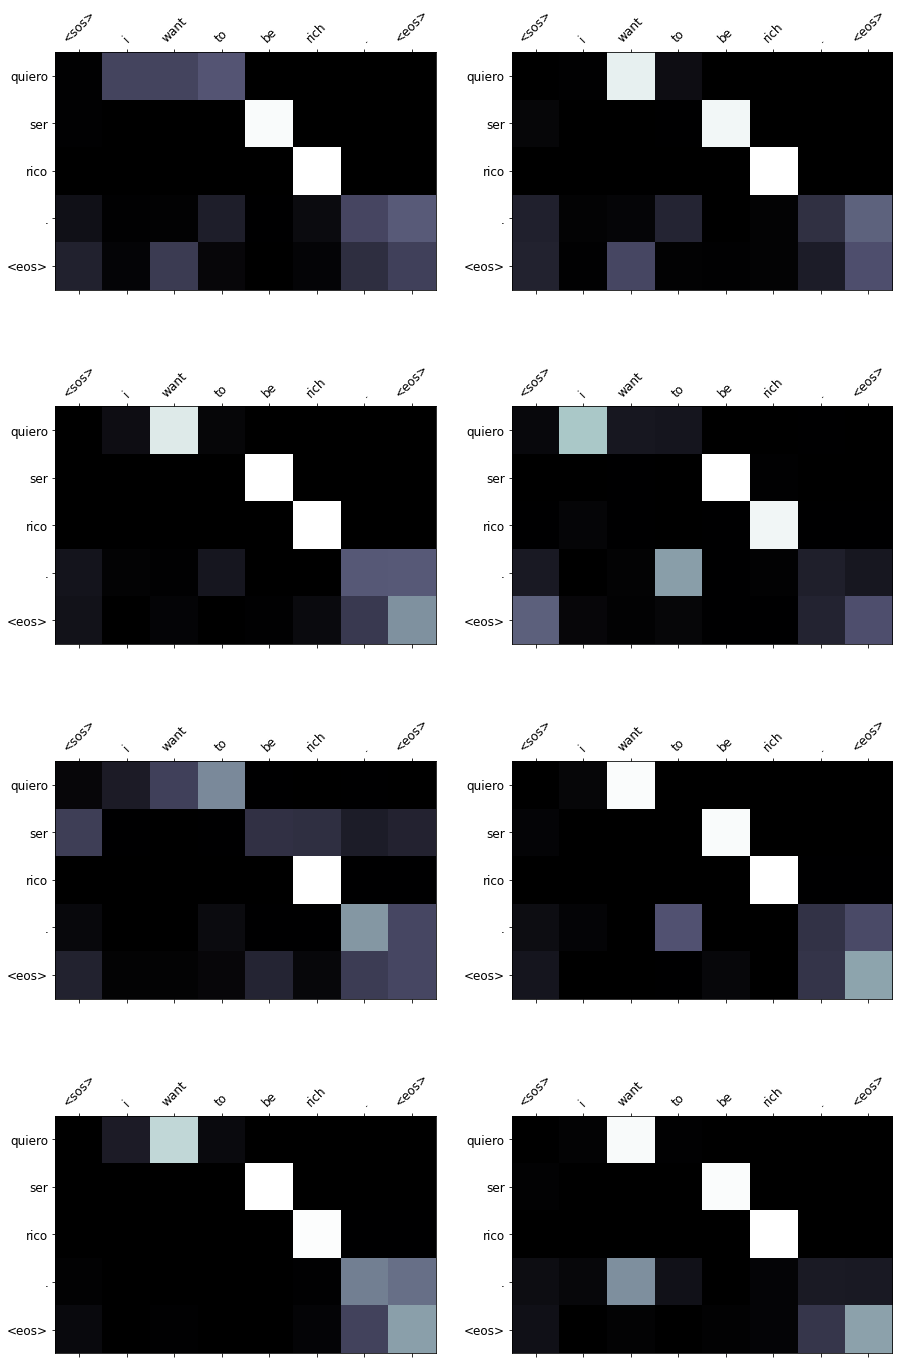

In [47]:
display_attention(src, translation, attention)

Finally, we'll look at an example from the test data.

In [48]:
example_idx = 10

src = vars(test_dataset.examples[example_idx])['es']
trg = vars(test_dataset.examples[example_idx])['eng']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['tom', "'s", 'bedroom', 'door', 'was', 'closed', '.']
trg = ['la', 'puerta', 'del', 'dormitorio', 'de', 'tom', 'estaba', 'cerrada', '.']


In [49]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['la', 'puerta', 'de', 'tom', 'estaba', 'cerrada', '.', '<eos>']


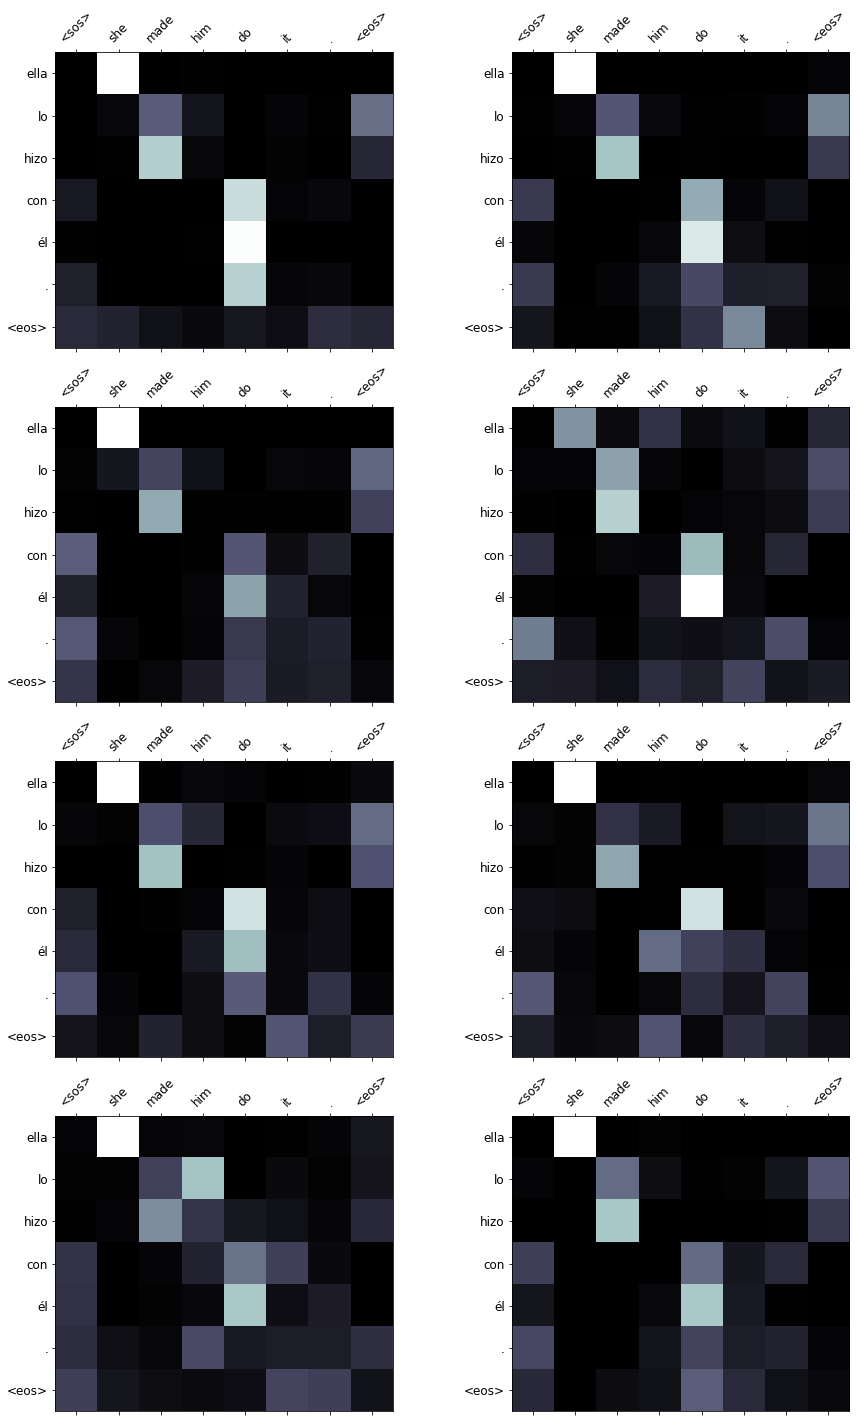

In [50]:
display_attention(src, translation, attention)

## BLEU

Finally we calculate the BLEU score for the Transformer.

In [51]:
!pip install torchtext==0.6.0

In [50]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['es']
        trg = vars(datum)['eng']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

We get a BLEU score of 35.08, which beats the 33.3 of the convolutional sequence-to-sequence model and 28.2 of the attention based RNN model. All this whilst having the least amount of parameters and the fastest training time!

In [51]:
bleu_score = calculate_bleu(test_dataset, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 41.80
